# This notebook aims to fill the gaps from the DOSE data set

It uses the UN WDI, and the complementary set of countries from DOSE. 

In [1]:
import json
import io
import re
import itertools as iter
import numpy as np
import os

# data

import pandas as pd
import ibis as ib
from ibis import _
ib.options.interactive = True

In [2]:
# The duckdb/ibis way require to either create an in-memory database at the moment of execution of the notebook, or saving the database in a file. 
conn = ib.connect('duckdb://')
conn.list_tables() # empty

[]

In [3]:
# loading the spatial extension.
res = conn.raw_sql("install spatial; load spatial")
print(res)

In [4]:
### A year of interest:

year = 2015

Reading in data

With **ibis**

In [5]:
dose = conn.read_csv("../datasets/DOSE/DOSE_V2.csv",table_name="dose",all_varchar = True)

In [6]:
wdi = conn.read_csv("../datasets/WDI_CSV_2024_06_28/WDICSV.csv",table_name="wdi")

In [7]:
# load extension first
res = conn.raw_sql("""INSTALL spatial;LOAD spatial;""")

In [8]:
conn.raw_sql("""CREATE OR REPLACE TABLE boundaries AS SELECT * FROM st_read("../datasets/boundaries/GADM/gadm_410.gpkg");""")
# alternative method
# conn.read_geo("datasets/boundaries/GADM/gadm_410.gpkg", table_name="boundaries")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [9]:
boundaries = conn.table("boundaries")

In [10]:
boundaries = boundaries.rename("snake_case")

In [11]:
boundary_countries = conn.sql("Select distinct(gid_0) from boundaries;").to_pandas().iloc[:,0].to_list()
print(len(boundary_countries))
boundary_countries

263


['COG',
 'REU',
 'RWA',
 'MAF',
 'KNA',
 'Z09',
 'SEN',
 'SGS',
 'ESP',
 'SWE',
 'TWN',
 'TJK',
 'UKR',
 'AGO',
 'ARM',
 'AUS',
 'BVT',
 'VGB',
 'BRN',
 'CPV',
 'KHM',
 'CYM',
 'TCD',
 'XCL',
 'CRI',
 'CUW',
 'FIN',
 'GGY',
 'IRL',
 'IMN',
 'ISR',
 'JAM',
 'KGZ',
 'LIE',
 'MWI',
 'MHL',
 'MYT',
 'MAR',
 'NPL',
 'NCL',
 'ZNC',
 'USA',
 'URY',
 'VIR',
 'QAT',
 'ROU',
 'VCT',
 'SXM',
 'SLB',
 'SWZ',
 'TKL',
 'TON',
 'ARE',
 'Z03',
 'ATA',
 'ARG',
 'BLR',
 'XCA',
 'CAF',
 'CHL',
 'DNK',
 'FRO',
 'PYF',
 'ATF',
 'GMB',
 'GTM',
 'KIR',
 'MLI',
 'MEX',
 'FSM',
 'NZL',
 'NIC',
 'NOR',
 'XPI',
 'VNM',
 'ZWE',
 'POL',
 'PRT',
 'CHE',
 'SYR',
 'BMU',
 'IOT',
 'BFA',
 'BDI',
 'EGY',
 'GNQ',
 'GEO',
 'DEU',
 'GIB',
 'GRC',
 'HTI',
 'HUN',
 'LAO',
 'LBY',
 'NLD',
 'NER',
 'PAK',
 'UZB',
 'VAT',
 'WSM',
 'SMR',
 'STP',
 'SYC',
 'Z02',
 'SGP',
 'SVN',
 'SOM',
 'TUV',
 'XAD',
 'ASM',
 'AIA',
 'AUT',
 'BHR',
 'BEL',
 'BLZ',
 'BTN',
 'BRA',
 'CHN',
 'CXR',
 'DOM',
 'SLV',
 'ETH',
 'GIN',
 'HND',
 'IDN',


In [12]:
# how to name tables properly ?
conn.list_tables()

['boundaries', 'dose', 'wdi']

### Inspection

In [13]:
dose.head()

┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ country ┃ region ┃ GID_0  ┃ GID_1   ┃ year   ┃ grp_lcu     ┃ pop    ┃ grp_pc_lcu ┃ ag_grp_pc_lcu ┃ man_grp_pc_lcu ┃ serv_grp_pc_lcu ┃ grp_pc_usd  ┃ ag_grp_pc_usd ┃ man_grp_pc_usd ┃ serv_grp_pc_usd ┃ grp_pc_lcu_2015 ┃ ag_grp_pc_lcu_2015 ┃ man_grp_pc_lcu_2015 ┃ serv_grp_pc_lcu_2015 ┃ grp_pc_usd_2015 ┃ ag_grp_pc_usd_2015 ┃ man_grp_pc_usd_2015 ┃ serv_grp_pc_usd_2015 ┃ grp_pc_lcu2015_usd ┃ ag_grp_pc_lcu2015_usd ┃ man_grp_pc_lcu2015_usd ┃ serv_grp_pc_lcu2015_usd ┃ cpi_2015    ┃ deflator_2015 ┃ fx          ┃ PPP         ┃ StructChange ┃ version ┃ T_a         ┃ P_a         ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ string  │ string │ string │ string  │ string │ string      │ string │ string     │ string        │ string         │ string          │ string      │ string        │ string         │ string          │ string          │ string             │ string              │ string               │ string          │ string             │ string              │ string               │ string             │ string                │ string                 │ string                  │ string      │ string        │ string      │ string      │ string       │ string  │ string      │ string      │
├─────────┼────────┼────────┼─────────┼────────┼─────────────┼────────┼────────────┼───────────────┼────────────────┼─────────────────┼─────────────┼───────────────┼────────────────┼─────────────────┼─────────────────┼────────────────────┼─────────────────────┼──────────────────────┼─────────────────┼────────────────────┼─────────────────────┼──────────────────────┼────────────────────┼───────────────────────┼────────────────────────┼─────────────────────────┼─────────────┼───────────────┼─────────────┼─────────────┼──────────────┼─────────┼─────────────┼─────────────┤
│ Albania │ Berat  │ ALB    │ ALB.1_1 │ 2010   │ 49416066001 │ 151375 │ 326448     │ NULL          │ NULL           │ NULL            │ 3140.842514 │ NULL          │ NULL           │ NULL            │ 345645.9835     │ NULL               │ NULL                │ NULL                 │ 3419.068968     │ NULL               │ NULL                │ NULL                 │ 2744.075141        │ NULL                  │ NULL                   │ NULL                    │ 104.7429508 │ 94.44576693   │ 103.9364434 │ 44.19621436 │ 0            │ 2       │ 13.12376773 │ 1573.116224 │
│ Albania │ Berat  │ ALB    │ ALB.1_1 │ 2011   │ 52603911678 │ 148160 │ 355048     │ NULL          │ NULL           │ NULL            │ 3518.986662 │ NULL          │ NULL           │ NULL            │ 367423.0111     │ NULL               │ NULL                │ NULL                 │ 3752.327886     │ NULL               │ NULL                │ NULL                 │ 2916.962438        │ NULL                  │ NULL                   │ NULL                    │ 113.2074664 │ 96.63194446   │ 100.8949547 │ 43.85768488 │ 0            │ 2     

In [14]:
dose.filter(_.country=="Ireland").head(3)

┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ country ┃ region ┃ GID_0  ┃ GID_1   ┃ year   ┃ grp_lcu     ┃ pop    ┃ grp_pc_lcu  ┃ ag_grp_pc_lcu ┃ man_grp_pc_lcu ┃ serv_grp_pc_lcu ┃ grp_pc_usd  ┃ ag_grp_pc_usd ┃ man_grp_pc_usd ┃ serv_grp_pc_usd ┃ grp_pc_lcu_2015 ┃ ag_grp_pc_lcu_2015 ┃ man_grp_pc_lcu_2015 ┃ serv_grp_pc_lcu_2015 ┃ grp_pc_usd_2015 ┃ ag_grp_pc_usd_2015 ┃ man_grp_pc_usd_2015 ┃ serv_grp_pc_usd_2015 ┃ grp_pc_lcu2015_usd ┃ ag_grp_pc_lcu2015_usd ┃ man_grp_pc_lcu2015_usd ┃ serv_grp_pc_lcu2015_usd ┃ cpi_2015    ┃ deflator_2015 ┃ fx          ┃ PPP      ┃ StructChange ┃ version ┃ T_a         ┃ P_a         ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ string  │ string │ string │ string  │ string │ string      │ string │ string      │ string        │ string         │ string          │ string      │ string        │ string         │ string          │ string          │ string             │ string              │ string               │ string          │ string             │ string              │ string               │ string             │ string                │ string                 │ string                  │ string      │ string        │ string      │ string   │ string       │ string  │ string      │ string      │
├─────────┼────────┼────────┼─────────┼────────┼─────────────┼────────┼─────────────┼───────────────┼────────────────┼─────────────────┼─────────────┼───────────────┼────────────────┼─────────────────┼─────────────────┼────────────────────┼─────────────────────┼──────────────────────┼─────────────────┼────────────────────┼─────────────────────┼──────────────────────┼────────────────────┼───────────────────────┼────────────────────────┼─────────────────────────┼─────────────┼───────────────┼─────────────┼──────────┼──────────────┼─────────┼─────────────┼─────────────┤
│ Ireland │ Carlow │ IRL    │ IRL.1_1 │ 1995   │ 398313875.4 │ 39479  │ 10089.25949 │ NULL          │ NULL           │ NULL            │ 12739.32373 │ NULL          │ NULL           │ NULL            │ 16779.57505     │ NULL               │ NULL                │ NULL                 │ 18557.45882     │ NULL               │ NULL                │ NULL                 │ 18609.66925        │ NULL                  │ NULL                   │ NULL                    │ 23.71212508 │ 60.12821814   │ 0.791977636 │ 0.801377 │ 0            │ 1       │ 10.16869158 │ 829.0329783 │
│ Ireland │ Carlow │ IRL    │ IRL.1_1 │ 1996   │ 426266829.9 │ 40310  │ 10574.71669 │ NULL          │ NULL           │ NULL            │ 13324.62109 │ NULL          │ NULL           │ NULL            │ 17191.81706     │ NULL               │ NULL                │ NULL                 │ 19061.0635      │ NULL               │ NULL                │ NULL                 │ 19066.87317        │ NULL                  │ NULL                   │ NULL                    │ 25.99313277 │ 61.5101746    │ 0.793622319 │ 0.80757  │ 0            │ 1       │ 9.09406520

In [15]:
wdi.head()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┓
┃ Country Name                ┃ Country Code ┃ Indicator Name                                                                   ┃ Indicator Code    ┃ 1960    ┃ 1961    ┃ 1962    ┃ 1963    ┃ 1964    ┃ 1965    ┃ 1966    ┃ 1967    ┃ 1968    ┃ 1969    ┃ 1970    ┃ 1971    ┃ 1972    ┃ 1973    ┃ 1974    ┃ 1975    ┃ 1976    ┃ 1977    ┃ 1978    ┃ 1979    ┃ 1980    ┃ 1981    ┃ 1982    ┃ 1983    ┃ 1984    ┃ 1985    ┃ 1986    ┃ 1987    ┃ 1988    ┃ 1989    ┃ 1990    ┃ 1991    ┃ 1992    ┃ 1993    ┃ 1994    ┃ 1995    ┃ 1996    ┃ 1997    ┃ 1998    ┃ 1999    ┃ 2000      ┃ 2001      ┃ 2002      ┃ 2003      ┃ 2004      ┃ 2005      ┃ 2006      ┃ 2007      ┃ 2008      ┃ 2009      ┃ 2010      ┃ 2011      ┃ 2012      ┃ 2013      ┃ 2014      ┃ 2015      ┃ 2016      ┃ 2017      ┃ 2018      ┃ 2019      ┃ 2020      ┃ 2021      ┃ 2022      ┃ 2023    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━┩
│ string                      │ string       │ string                                                                           │ string            │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64 │
├─────────────────────────────┼──────────────┼──────────────────────────────────────────────────────────────────────────────────┼───────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────

#### Changing column names for easier manipulation

In [16]:
# cool function from ibis, no need for the previous cells, althought the python dict comprehension method is cool as well.
wdi = wdi.rename("snake_case")
dose = dose.rename("snake_case")

In [17]:
wdi.columns

['country_name',
 'country_code',
 'indicator_name',
 'indicator_code',
 '1960',
 '1961',
 '1962',
 '1963',
 '1964',
 '1965',
 '1966',
 '1967',
 '1968',
 '1969',
 '1970',
 '1971',
 '1972',
 '1973',
 '1974',
 '1975',
 '1976',
 '1977',
 '1978',
 '1979',
 '1980',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 '2022',
 '2023']

In [18]:
dose.columns

['country',
 'region',
 'gid_0',
 'gid_1',
 'year',
 'grp_lcu',
 'pop',
 'grp_pc_lcu',
 'ag_grp_pc_lcu',
 'man_grp_pc_lcu',
 'serv_grp_pc_lcu',
 'grp_pc_usd',
 'ag_grp_pc_usd',
 'man_grp_pc_usd',
 'serv_grp_pc_usd',
 'grp_pc_lcu_2015',
 'ag_grp_pc_lcu_2015',
 'man_grp_pc_lcu_2015',
 'serv_grp_pc_lcu_2015',
 'grp_pc_usd_2015',
 'ag_grp_pc_usd_2015',
 'man_grp_pc_usd_2015',
 'serv_grp_pc_usd_2015',
 'grp_pc_lcu2015_usd',
 'ag_grp_pc_lcu2015_usd',
 'man_grp_pc_lcu2015_usd',
 'serv_grp_pc_lcu2015_usd',
 'cpi_2015',
 'deflator_2015',
 'fx',
 'ppp',
 'struct_change',
 'version',
 't_a',
 'p_a']

#### Country codes in the data sets

In [19]:
wdi_countries = np.unique(wdi.country_code.__array__()).tolist()

In [20]:
len(wdi_countries)

266

In [21]:
dose_countries = list(dose.gid_0.to_pandas().unique())
dose_countries

['ALB',
 'ARG',
 'AUS',
 'AUT',
 'AZE',
 'BHS',
 'BLR',
 'BEL',
 'BOL',
 'BIH',
 'BRA',
 'BGR',
 'CAN',
 'CHL',
 'CHN',
 'COL',
 'HRV',
 'CZE',
 'DNK',
 'ECU',
 'EGY',
 'EST',
 'ETH',
 'FIN',
 'FRA',
 'GEO',
 'DEU',
 'GRC',
 'GTM',
 'HND',
 'HUN',
 'IND',
 'IDN',
 'IRN',
 'IRL',
 'ITA',
 'JPN',
 'KAZ',
 'KEN',
 'KGZ',
 'LAO',
 'LVA',
 'LTU',
 'MKD',
 'MYS',
 'MEX',
 'MNG',
 'MAR',
 'MOZ',
 'NPL',
 'NLD',
 'ANT',
 'NZL',
 'NGA',
 'NOR',
 'PAK',
 'PAN',
 'PRY',
 'PER',
 'PHL',
 'POL',
 'PRT',
 'ROU',
 'RUS',
 'SRB',
 'SVK',
 'SVN',
 'ZAF',
 'KOR',
 'ESP',
 'LKA',
 'SWE',
 'CHE',
 'TZA',
 'THA',
 'TUR',
 'ARE',
 'GBR',
 'USA',
 'UKR',
 'URY',
 'UZB',
 'VNM']

## Missing regions
Determining the missing regions from DOSE using the 3 letter country codes compared to the equivalent variable in WDI indicators

In [22]:
missing_regions = [x for x in wdi_countries if x not in dose_countries and x in boundary_countries]

In [23]:
len(missing_regions)

131

In [24]:
missing_regions

['ABW',
 'AFG',
 'AGO',
 'AND',
 'ARM',
 'ASM',
 'ATG',
 'BDI',
 'BEN',
 'BFA',
 'BGD',
 'BHR',
 'BLZ',
 'BMU',
 'BRB',
 'BRN',
 'BTN',
 'BWA',
 'CAF',
 'CIV',
 'CMR',
 'COD',
 'COG',
 'COM',
 'CPV',
 'CRI',
 'CUB',
 'CUW',
 'CYM',
 'CYP',
 'DJI',
 'DMA',
 'DOM',
 'DZA',
 'ERI',
 'FJI',
 'FRO',
 'FSM',
 'GAB',
 'GHA',
 'GIB',
 'GIN',
 'GMB',
 'GNB',
 'GNQ',
 'GRD',
 'GRL',
 'GUM',
 'GUY',
 'HTI',
 'IMN',
 'IRQ',
 'ISL',
 'ISR',
 'JAM',
 'JOR',
 'KHM',
 'KIR',
 'KNA',
 'KWT',
 'LBN',
 'LBR',
 'LBY',
 'LCA',
 'LIE',
 'LSO',
 'LUX',
 'MAF',
 'MCO',
 'MDA',
 'MDG',
 'MDV',
 'MHL',
 'MLI',
 'MLT',
 'MMR',
 'MNE',
 'MNP',
 'MRT',
 'MUS',
 'MWI',
 'NAM',
 'NCL',
 'NER',
 'NIC',
 'NRU',
 'OMN',
 'PLW',
 'PNG',
 'PRI',
 'PRK',
 'PSE',
 'PYF',
 'QAT',
 'RWA',
 'SAU',
 'SDN',
 'SEN',
 'SGP',
 'SLB',
 'SLE',
 'SLV',
 'SMR',
 'SOM',
 'SSD',
 'STP',
 'SUR',
 'SWZ',
 'SXM',
 'SYC',
 'SYR',
 'TCA',
 'TCD',
 'TGO',
 'TJK',
 'TKM',
 'TLS',
 'TON',
 'TTO',
 'TUN',
 'TUV',
 'UGA',
 'VCT',
 'VEN',
 'VGB',


### WDI of interest

getting the variables of interest from the WDI index for the missing countries in the DOSE data set.

In [25]:
# should not be null
wdi.filter(_.country_code.isin(missing_regions)).order_by("country_name").head(3)

┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ country_name ┃ country_code ┃ indicator_name                                    ┃ indicator_code ┃ 1960    ┃ 1961    ┃ 1962    ┃ 1963    ┃ 1964    ┃ 1965    ┃ 1966    ┃ 1967    ┃ 1968    ┃ 1969    ┃ 1970    ┃ 1971    ┃ 1972    ┃ 1973    ┃ 1974    ┃ 1975    ┃ 1976    ┃ 1977    ┃ 1978    ┃ 1979    ┃ 1980    ┃ 1981    ┃ 1982    ┃ 1983    ┃ 1984    ┃ 1985    ┃ 1986    ┃ 1987    ┃ 1988    ┃ 1989    ┃ 1990    ┃ 1991    ┃ 1992    ┃ 1993    ┃ 1994    ┃ 1995    ┃ 1996    ┃ 1997    ┃ 1998    ┃ 1999    ┃ 2000         ┃ 2001         ┃ 2002         ┃ 2003         ┃ 2004         ┃ 2005         ┃ 2006         ┃ 2007         ┃ 2008         ┃ 2009         ┃ 2010         ┃ 2011         ┃ 2012         ┃ 2013         ┃ 2014         ┃ 2015         ┃ 2016         ┃ 2017         ┃ 2018         ┃ 2019         ┃ 2020         ┃ 2021         ┃ 2022         ┃ 2023    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ string       │ string       │ string                                            │ string         │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64      │ float64 │
├──────────────┼──────────────┼───────────────────────────────────────────────────┼────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼─

### Indicators 

#### WDI

More on the indicators considered from the wdi website : https://datacatalog.worldbank.org/search/dataset/0037712/World-Development-Indicators.


##### Agriculture, forestry, and fishing, value added (ppercentage of GDP)

Agriculture corresponds to ISIC divisions 1-5 and includes forestry, hunting, and fishing, as well as cultivation of crops and livestock production. Value added is the net output of a sector after adding up all outputs and subtracting intermediate inputs. It is calculated without making deductions for depreciation of fabricated assets or depletion and degradation of natural resources. The origin of value added is determined by the International Standard Industrial Classification (ISIC), revision 3. Note: For VAB countries, gross value added at factor cost is used as the denominator.

##### Industry (including construction), value added (% of GDP)

Industry corresponds to ISIC divisions 10-45 and includes manufacturing (ISIC divisions 15-37). It comprises value added in mining, manufacturing (also reported as a separate subgroup), construction, electricity, water, and gas. Value added is the net output of a sector after adding up all outputs and subtracting intermediate inputs. It is calculated without making deductions for depreciation of fabricated assets or depletion and degradation of natural resources. The origin of value added is determined by the International Standard Industrial Classification (ISIC), revision 3. Note: For VAB countries, gross value added at factor cost is used as the denominator.

##### Manufacturing, value added (% of GDP)

Manufacturing refers to industries belonging to ISIC divisions 15-37. Value added is the net output of a sector after adding up all outputs and subtracting intermediate inputs. It is calculated without making deductions for depreciation of fabricated assets or depletion and degradation of natural resources. The origin of value added is determined by the International Standard Industrial Classification (ISIC), revision 3. Note: For VAB countries, gross value added at factor cost is used as the denominator.

##### Services, value added (% of GDP)

Services correspond to ISIC divisions 50-99 and they include value added in wholesale and retail trade (including hotels and restaurants), transport, and government, financial, professional, and personal services such as education, health care, and real estate services. Also included are imputed bank service charges, import duties, and any statistical discrepancies noted by national compilers as well as discrepancies arising from rescaling. Value added is the net output of a sector after adding up all outputs and subtracting intermediate inputs. It is calculated without making deductions for depreciation of fabricated assets or depletion and degradation of natural resources. The industrial origin of value added is determined by the International Standard Industrial Classification (ISIC), revision 3 or 4.

#### <font color='green'>Manufacturing is included in construction !!!</font>


### DOSE

<!-- ![Dose ISIC classification](../img/dose_isic_table.png) -->
<center>
<img src="../img/dose_isic_table.png" width="50%">
</center>

<!-- # from IPython.display import Image
# Image(filename="../img/dose_isic_table.png", width=700) -->

### Remarks

* The ISIC divisions 46-49 (inclusive) seem not to be covered in WDI, the are in the *services* category in DOSE.
* In order to match with DOSE, the *industry* variable from WDI (which includes *manufacturing*) is renamed into *manufacturing* later on.

In [26]:
indicators = list(wdi.indicator_name.to_pandas().unique())
indicators[0:9]

['Access to clean fuels and technologies for cooking (% of population)',
 'Access to clean fuels and technologies for cooking, rural (% of rural population)',
 'Access to clean fuels and technologies for cooking, urban (% of urban population)',
 'Access to electricity (% of population)',
 'Access to electricity, rural (% of rural population)',
 'Access to electricity, urban (% of urban population)',
 'Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)',
 'Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)',
 'Account ownership at a financial institution or with a mobile-money-service provider, male (% of population ages 15+)']

In [27]:
# subsetting the variables with relevant currency as constant 2015 values
# [x for x in indicators if re.search(string=x,pattern="constant 2015 US\\$")]
# [x for x in indicators if re.search(string=x,pattern="\\% of GDP")]

In [28]:
# manually getting the useful variables and storing in a dict with simplified names.
indicators_of_intereset_perc = {
    "country" : "country_name",
    "grp_usd_2015" : 'GDP (constant 2015 US$)',
    "gdp_cap" : "GDP per capita (constant 2015 US$)",
    "industry_perc" : "Industry (including construction), value added (% of GDP)",
    "services_perc" : "Services, value added (% of GDP)",
    "agriculture_perc" : "Agriculture, forestry, and fishing, value added (% of GDP)",
}

indicators_of_intereset_usd_2015 = {
    "country" : "country_name",
    "grp_usd_2015" : 'GDP (constant 2015 US$)',
    "gdp_cap" : "GDP per capita (constant 2015 US$)",
    "industry_usd_2015" : "Industry (including construction), value added (constant 2015 US$)",
    "services_usd_2015" : "Services, value added (constant 2015 US$)",
    "agriculture_usd_2015" : "Agriculture, forestry, and fishing, value added (constant 2015 US$)",
    
}


In [29]:
# select here which dict of indicators to use : the _usd_2015 is considered only at this point
indicators_of_intereset = indicators_of_intereset_usd_2015

In [30]:
if str(year) not in wdi.columns:
    raise ValueError("No such year ({}) in WDI data".format(year))

In [31]:
wdi_cols = ["country_name","country_code","indicator_name","indicator_code",str(year)]

# keeping indicators of interest and countries of interest
wdi_of_interest = wdi.select(wdi_cols).filter(_.indicator_name.isin(indicators_of_intereset.values()))

In [32]:
# get the data of interest into a pandas df
wdi_df = wdi_of_interest.filter(_.country_code.isin(missing_regions)).to_pandas()

In [33]:
print(wdi_df.shape)
wdi_df.head(5)

(655, 5)


,country_name,country_code,indicator_name,indicator_code,2015
0,El Salvador,SLV,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.KD,1.296080e+09
1,El Salvador,SLV,GDP (constant 2015 US$),NY.GDP.MKTP.KD,2.343824e+10
2,El Salvador,SLV,GDP per capita (constant 2015 US$),NY.GDP.PCAP.KD,3.761514e+03
3,El Salvador,SLV,"Industry (including construction), value added...",NV.IND.TOTL.KD,5.927280e+09
4,El Salvador,SLV,"Services, value added (constant 2015 US$)",NV.SRV.TOTL.KD,1.406600e+10


## WDI data transformed
pivoting the data WDI data

In [34]:
wdi_df_var = wdi_df.pivot(columns=["indicator_name",],values=[str(year)],index=["country_name","country_code"]).reset_index()

In [35]:
wdi_df_var.rename(columns={v:k for (k,v) in indicators_of_intereset.items()} # inverting the indicators of interest to rename columns
                  ,inplace=True)

In [36]:
wdi_df_var.columns = [x[1] if x[1]!='' else x[0] for x in wdi_df_var.columns]

In [37]:
wdi_df_var.columns = [x.replace("industry", "manufacturing") if re.search(string=x,pattern="industry_") else x for x in wdi_df_var.columns]

In [38]:
print(wdi_df_var.shape)
wdi_df_var.head(3)

(131, 7)


,country,country_code,agriculture_usd_2015,grp_usd_2015,gdp_cap,manufacturing_usd_2015,services_usd_2015
0,Afghanistan,AFG,3.948217e+09,1.913422e+10,566.881130,4.233263e+09,1.018616e+10
1,Algeria,DZA,1.974833e+10,1.874939e+11,4741.499770,6.141643e+10,9.770374e+10
2,American Samoa,ASM,NaN,6.730000e+08,13101.541816,NaN,NaN


In [39]:
wdi_df_var[wdi_df_var.isna().any(axis=1)]

,country,country_code,agriculture_usd_2015,grp_usd_2015,gdp_cap,manufacturing_usd_2015,services_usd_2015
2,American Samoa,ASM,NaN,6.730000e+08,13101.541816,NaN,NaN
16,British Virgin Islands,VGB,NaN,NaN,NaN,NaN,NaN
39,Eritrea,ERI,NaN,NaN,NaN,NaN,NaN
47,Gibraltar,GIB,NaN,NaN,NaN,NaN,NaN
50,Guam,GUM,NaN,5.799000e+09,34522.377930,NaN,NaN
61,Kiribati,KIR,NaN,1.915723e+08,1641.480977,NaN,NaN
62,"Korea, Dem. People's Rep.",PRK,NaN,NaN,NaN,NaN,NaN
68,Liechtenstein,LIE,NaN,6.268515e+09,167809.269875,2.335665e+09,NaN
80,Monaco,MCO,NaN,6.261650e+09,170338.680381,1.102080e+09,5.159459e+09
84,Nauru,NRU,NaN,8.486344e+07,7587.254410,NaN,NaN


In [40]:
# without 'manufacturing' it makes more sense:
indicator_columns = [x for x in wdi_df_var.columns if re.search(string=x,pattern="(services_)|(agriculture_)|(manufacturing_)")]
indicator_columns

['agriculture_usd_2015', 'manufacturing_usd_2015', 'services_usd_2015']

<Axes: >

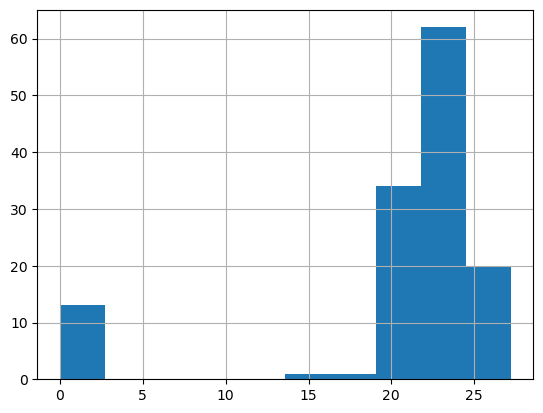

In [41]:
wdi_df_var[indicator_columns].sum(axis=1).apply(np.log1p).hist()

## Combining the data sets

In [42]:
# inspecting the 
dose.year.value_counts().order_by("year").to_pandas().tail(10)

,year,year_count
52,2011,1420
53,2012,1476
54,2013,1564
55,2014,1548
56,2015,1524
57,2016,1521
58,2017,1518
59,2018,1335
60,2019,1039
61,2020,354


In [43]:
dose.columns[0:9]

['country',
 'region',
 'gid_0',
 'gid_1',
 'year',
 'grp_lcu',
 'pop',
 'grp_pc_lcu',
 'ag_grp_pc_lcu']

In [44]:
# wdi.select("country_code",*[str(i) for i in range(1960,2022,1) if str(i) in wdi.columns])

### Using the year variable assinged earlier

In [45]:
dose_year = dose.filter(_.year==str(year)).to_pandas()

In [46]:
# due to the way na values are written in the data set, all the data had to be read as strings, changing this here.
dose_year.replace(to_replace="#N/A",value=np.nan,inplace=True)
dose_year.head(3)

,country,region,gid_0,gid_1,year,grp_lcu,pop,grp_pc_lcu,ag_grp_pc_lcu,man_grp_pc_lcu,...,man_grp_pc_lcu2015_usd,serv_grp_pc_lcu2015_usd,cpi_2015,deflator_2015,fx,ppp,struct_change,version,t_a,p_a
0,Albania,Berat,ALB,ALB.1_1,2015,54691123900,136904,399485.2152,None,None,...,None,None,100,100,125.9608304,42.70570052,3,2,13.50185305,1093.56268
1,Albania,Dibër,ALB,ALB.2_1,2015,46850206200,130056,360231.0251,None,None,...,None,None,100,100,125.9608304,42.70570052,3,2,10.45442675,1175.134798
2,Albania,Durrës,ALB,ALB.3_1,2015,1.40E+11,279097,502550.8411,None,None,...,None,None,100,100,125.9608304,42.70570052,3,2,16.16559071,1047.35031


On the duckdb end all the data was stored as strings becuase the NA values were not interpretable as numeric. so converting back 


In [47]:
# have a look at the columns
dose_year.columns

Index(['country', 'region', 'gid_0', 'gid_1', 'year', 'grp_lcu', 'pop',
       'grp_pc_lcu', 'ag_grp_pc_lcu', 'man_grp_pc_lcu', 'serv_grp_pc_lcu',
       'grp_pc_usd', 'ag_grp_pc_usd', 'man_grp_pc_usd', 'serv_grp_pc_usd',
       'grp_pc_lcu_2015', 'ag_grp_pc_lcu_2015', 'man_grp_pc_lcu_2015',
       'serv_grp_pc_lcu_2015', 'grp_pc_usd_2015', 'ag_grp_pc_usd_2015',
       'man_grp_pc_usd_2015', 'serv_grp_pc_usd_2015', 'grp_pc_lcu2015_usd',
       'ag_grp_pc_lcu2015_usd', 'man_grp_pc_lcu2015_usd',
       'serv_grp_pc_lcu2015_usd', 'cpi_2015', 'deflator_2015', 'fx', 'ppp',
       'struct_change', 'version', 't_a', 'p_a'],
      dtype='object')

In [48]:
# The columns that we will use later will be multiplied, so this step is essential.
float_cols = dose_year.filter(regex="(lcu)|(usd)|(cpi)|(pop)|(year)|(T_a)|(P_a)|(PPP)|(2015)").columns.unique()
dose_year[float_cols] = dose_year[float_cols].astype(float)

## Filling population gaps in DOSE
The missing *population* values generates missing values when converting from per capita values back into absolute values.
#### Converting per capita into absolute values with the population variable.


In [49]:
dose_year.head(5)

,country,region,gid_0,gid_1,year,grp_lcu,pop,grp_pc_lcu,ag_grp_pc_lcu,man_grp_pc_lcu,...,man_grp_pc_lcu2015_usd,serv_grp_pc_lcu2015_usd,cpi_2015,deflator_2015,fx,ppp,struct_change,version,t_a,p_a
0,Albania,Berat,ALB,ALB.1_1,2015.0,5.469112e+10,136904.0,399485.2152,NaN,NaN,...,NaN,NaN,100.0,100.0,125.9608304,42.70570052,3,2,13.50185305,1093.56268
1,Albania,Dibër,ALB,ALB.2_1,2015.0,4.685021e+10,130056.0,360231.0251,NaN,NaN,...,NaN,NaN,100.0,100.0,125.9608304,42.70570052,3,2,10.45442675,1175.134798
2,Albania,Durrës,ALB,ALB.3_1,2015.0,1.400000e+11,279097.0,502550.8411,NaN,NaN,...,NaN,NaN,100.0,100.0,125.9608304,42.70570052,3,2,16.16559071,1047.35031
3,Albania,Elbasan,ALB,ALB.4_1,2015.0,1.000000e+11,289136.0,346548.9099,NaN,NaN,...,NaN,NaN,100.0,100.0,125.9608304,42.70570052,3,2,12.9849634,1017.524637
4,Albania,Fier,ALB,ALB.5_1,2015.0,1.690000e+11,306561.0,552703.4714,NaN,NaN,...,NaN,NaN,100.0,100.0,125.9608304,42.70570052,3,2,16.91313816,978.7869504


In [50]:
# filling some extra missing values of population to reconstruct the economic indicators. From sources on the net.
missing_pop = dose_year.loc[dose_year["pop"].isna(),["country","region","pop"]].copy()
missing_pop.head()
# writing out this file to refer to the missing values
missing_pop["region"].to_csv("missing_pop.csv",index=False) 

missing_pop.set_index("region",inplace=True)


In [51]:
## strangely, Ireland is missing from the data, using it's census data to fill the gaps.
# https://data.gov.ie/dataset/population-classified-by-area 

# this data set : https://www.cso.ie/en/media/csoie/census/documents/saps2011files/AllThemesTablesCTY.csv

ireland = pd.read_csv("../datasets/support_data/ireland/AllThemesTablesCTY.csv"
                      ,encoding="UTF-8")
ireland.columns = [x.lower() for x in ireland.columns]
ireland.head(3)

# manually replaced Dublin City -> Dublin, Laois -> Laoighis in the data set.

# to many columns
ireland = ireland[["t1_1agett","geogdesc"]]


In [52]:
# renaming consistently
ireland.rename(columns={"t1_1agett":"pop"
                        ,"geogdesc":"region"},inplace=True)

# few cases to treat individually
tipperary_pop = ireland.loc[ireland.region.isin(["Tipperary North","Tipperary South"]),"pop"].sum()

missing_case = pd.DataFrame([{"region" : "Tipperary", "pop" : tipperary_pop}])

ireland = pd.concat([ireland,missing_case])

ireland.set_index("region",inplace=True)
ireland.head()

,pop
region,
Carlow,54612
Dublin,527612
South Dublin,265205
Fingal,273991
Dún Laoghaire-Rathdown,206261


In [53]:
missing_index = [x for x in ireland.index if x in missing_pop.index]


In [54]:
missing_pop.loc[missing_index,"pop"] = ireland.loc[missing_index,"pop"]

In [55]:
# yey, ireland is in.
missing_pop.loc[missing_pop.country=="Ireland"].tail(3)

,country,pop
region,,
Westmeath,Ireland,86164.0
Wexford,Ireland,145320.0
Wicklow,Ireland,136640.0


In [56]:
# need to go back and forth between indexing based on the region and putting it back into the columns, the R function match() does that well. 
missing_pop.reset_index(inplace=True,drop=False)
missing_pop.head()

,region,country,pop
0,Neuquen,Argentina,NaN
1,Tucuman,Argentina,NaN
2,Mato Grosso Do Sul,Brazil,NaN
3,Rio De Janeiro,Brazil,NaN
4,Rio Grande Do Norte,Brazil,NaN


In [57]:
# the fully manual bit, took some time.

# Argentina
missing_pop.loc[missing_pop.region=="Neuquen","pop"] = 744_592 # statista : https://www.statista.com/statistics/1413909/population-by-group-age-gender-neuquen-argentina
missing_pop.loc[missing_pop.region=="Tucuman","pop"] = 1.593e6 # wiki

# Brasil
missing_pop.loc[missing_pop.region=="Mato Grosso Do Sul","pop"] = 2_833_742 # https://www.britannica.com/place/Mato-Grosso-do-Sul
missing_pop.loc[missing_pop.region=="Rio De Janeiro","pop"] = 6_625_849 # https://www.britannica.com/place/Rio-de-Janeiro-Brazil
missing_pop.loc[missing_pop.region=="Rio Grande Do Norte","pop"] = 3_302_729 # https://cidades.ibge.gov.br/brasil/rn/panorama
missing_pop.loc[missing_pop.region=="Rio Grande Do Sul","pop"] = 11_329_605 # https://www.ceicdata.com/en/brazil/population/population-south-rio-grande-do-sul

# Canada
missing_pop.loc[missing_pop.region=="Newfoundland And Labrador","pop"] = 541_391 # https://www.gov.nl.ca/fin/economics/eb-population/

#Colombia
missing_pop.loc[missing_pop.region=="Norte de Santander","pop"] = 1_617_209 # https://www.citypopulation.de/en/colombia/admin/54__norte_de_santander/

# croatia
missing_pop.loc[missing_pop.region=="Slavonskibrod-Posavina","pop"] = 130_267 # https://www.citypopulation.de/en/croatia/admin/12__brod_posavina/

# Kazakhstan
missing_pop.loc[missing_pop.region=="Aktobe","pop"] = 944_600 # https://stat.gov.kz/en/region/aktobe/
missing_pop.loc[missing_pop.region=="Atirau","pop"] = 708_500 # https://stat.gov.kz/en/region/atyrau/
missing_pop.loc[missing_pop.region=="East Kazakhstan","pop"] = 731_246 # https://www.citypopulation.de/en/kazakhstan/cities/
missing_pop.loc[missing_pop.region=="Kostanay","pop"] = 827_900 # https://stat.gov.kz/en/region/kostanay/
missing_pop.loc[missing_pop.region=="North Kazakhstan","pop"] = 540_700 # 

# south Korea
missing_pop.loc[missing_pop.region=="Gangwond-do","pop"] = 1_521_763 # https://www.citypopulation.de/en/southkorea/admin/32__gangwon_do/

# Tanzania
missing_pop.loc[missing_pop.region=="Arusha","pop"] = 2_356_255 # https://www.citypopulation.de/en/tanzania/admin/02__arusha/
missing_pop.loc[missing_pop.region=="Dar es salaam","pop"] = 8_161_231 # https://worldpopulationreview.com/cities/tanzania/dar-es-salaam
missing_pop.loc[missing_pop.region=="Dodoma","pop"] = 3_085_625 # https://www.citypopulation.de/en/tanzania/admin/01__dodoma/
missing_pop.loc[missing_pop.region=="Geita","pop"] = 2_977_608 # https://www.citypopulation.de/en/tanzania/admin/25__geita
missing_pop.loc[missing_pop.region=="Iringa","pop"] = 1_192_728 # http://www.citypopulation.de/en/tanzania/admin/11__iringa/
missing_pop.loc[missing_pop.region=="Kagera","pop"] = 2_989_299 # https://www.citypopulation.de/en/tanzania/admin/18/
missing_pop.loc[missing_pop.region=="Katavi","pop"] = 1_152_958 # https://citypopulation.de/en/tanzania/admin/23__katavi/
missing_pop.loc[missing_pop.region=="Kigoma","pop"] = 2_470_967 # https://citypopulation.de/en/tanzania/admin/
missing_pop.loc[missing_pop.region=="Kilimanjaro","pop"] = 1_861_934 # ---
missing_pop.loc[missing_pop.region=="Lindi","pop"] = 1_194_028 # ---
missing_pop.loc[missing_pop.region=="Manyara","pop"] = 1_892_502 # ---
missing_pop.loc[missing_pop.region=="Mara","pop"] = 2_372_015 # ---
missing_pop.loc[missing_pop.region=="Mbeya","pop"] = 2_343_754 # ---
missing_pop.loc[missing_pop.region=="Morogoro","pop"] = 3_197_104 # ---
missing_pop.loc[missing_pop.region=="Mtwara","pop"] = 1_634_947 # ---
missing_pop.loc[missing_pop.region=="Mwanza","pop"] = 3_699_872 # ---
missing_pop.loc[missing_pop.region=="Njombe","pop"] = 889_946 # ---
missing_pop.loc[missing_pop.region=="Pwani","pop"] = 2_024_947 # ---
missing_pop.loc[missing_pop.region=="Rukwa","pop"] = 1_540_519 # ---
missing_pop.loc[missing_pop.region=="Ruvuma","pop"] = 1_848_794 # ---
missing_pop.loc[missing_pop.region=="Shinyanga","pop"] = 2_241_299 # ---
missing_pop.loc[missing_pop.region=="Singida","pop"] = 2_008_058 # ---
missing_pop.loc[missing_pop.region=="Tabora","pop"] = 3_391_679 # ---
missing_pop.loc[missing_pop.region=="Tanga","pop"] = 2_615_597 # ---

# Ukraine
missing_pop.loc[missing_pop.region=="Dnipropetrovsk","pop"] = 1_145_065 # https://www.citypopulation.de/en/ukraine/
missing_pop.loc[missing_pop.region=="Kyiv City","pop"] = 2_952_301 # https://www.citypopulation.de/en/ukraine/kievcity/

In [58]:
# no 'fx' is na
# dose_year[dose_year["fx"].isna()]
# NA for gid_0=="ANT"
# dose_year[dose_year["deflator_2015"].isna()]
# # dose_year[dose_year.gid_0=="ANT"]
# lcu_vars = [x for x in dose_year.columns if re.search(string=x,pattern="_lcu")]
# dose_year[lcu_vars].isna() 

### Putting the missing populations back in

In [59]:
dose_year.set_index("region",inplace=True)
missing_pop.set_index("region",inplace=True)

In [60]:
# yeahhhh
dose_year.loc[missing_pop.index,"pop"] = missing_pop["pop"]

In [61]:
# resetting back the index.
dose_year.reset_index(inplace=True,drop=False)

## Converting to absolute GDP values
Computing grp values in usd_2015.

In [62]:
dose_year["agriculture_usd_2015"] = dose_year["ag_grp_pc_usd_2015"]*dose_year["pop"]
dose_year["manufacturing_usd_2015"] = dose_year["man_grp_pc_usd_2015"]*dose_year["pop"]
dose_year["services_usd_2015"] = dose_year["serv_grp_pc_usd_2015"]*dose_year["pop"]
dose_year["grp_usd_2015"] = dose_year["grp_pc_usd_2015"]*dose_year["pop"]

### missing values from lcu and usd

In [63]:
# dose_year.loc[dose_year.filter(regex="_lcu_").isna().any(axis=1),dose_year.filter(regex="_usd_").columns]
dose_year.loc[dose_year.filter(regex="^grp_pc_lcu_").isna().any(axis=1),dose_year.filter(regex="(_usd_)|(gid_)").columns]

,gid_0,gid_1,grp_pc_usd_2015,ag_grp_pc_usd_2015,man_grp_pc_usd_2015,serv_grp_pc_usd_2015,agriculture_usd_2015,manufacturing_usd_2015,services_usd_2015,grp_usd_2015
779,ANT,BES.1_1,24649.56361,NaN,NaN,NaN,NaN,NaN,NaN,4.660000e+08
780,ANT,BES.2_1,25952.51242,NaN,NaN,NaN,NaN,NaN,NaN,4.700000e+07
781,ANT,BES.3_1,34562.80629,NaN,NaN,NaN,NaN,NaN,NaN,1.340000e+08


In [64]:
# dose_year.loc[dose_year.filter(regex="_lcu_").isna().any(axis=1),dose_year.filter(regex="_lcu_").columns]
dose_year.loc[dose_year.filter(regex="^grp_pc_usd_").isna().any(axis=1),dose_year.filter(regex="(_usd_)|(gid_)").columns]

,gid_0,gid_1,grp_pc_usd_2015,ag_grp_pc_usd_2015,man_grp_pc_usd_2015,serv_grp_pc_usd_2015,agriculture_usd_2015,manufacturing_usd_2015,services_usd_2015,grp_usd_2015


In [95]:
dose_year.grp_pc_usd_2015.isna().any()

False

In [66]:
dose_year[dose_year["pop"].isna()]

,region,country,gid_0,gid_1,year,grp_lcu,pop,grp_pc_lcu,ag_grp_pc_lcu,man_grp_pc_lcu,...,fx,ppp,struct_change,version,t_a,p_a,agriculture_usd_2015,manufacturing_usd_2015,services_usd_2015,grp_usd_2015
865,NaN,Philippines,PHL,PHL.109_1,2015.0,9.918561e+10,NaN,2.365159e+04,14387.34929,1179.344398,...,45.50283994,19.00100899,3,1,NaN,NaN,NaN,NaN,NaN,NaN
1206,NaN,Tanzania,TZA,None,2015.0,NaN,NaN,1.567157e+06,NaN,NaN,...,1991.390964,803.8115234,3,2,None,None,NaN,NaN,NaN,NaN


### Do things add up ? 

### Data sets light

In [67]:
# the light version is reduced to the variables of interest only. This includes a specific year, sector and total gdp(grp) values.
dose_light = dose_year[["country","gid_0","gid_1","grp_usd_2015","services_usd_2015","manufacturing_usd_2015","agriculture_usd_2015"]].copy()

In [68]:
dose_light[dose_light.isna().any(axis=1)] # Tanzania is missing completely

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,Albania,ALB,ALB.1_1,4.341915e+08,NaN,NaN,NaN
1,Albania,ALB,ALB.2_1,3.719427e+08,NaN,NaN,NaN
2,Albania,ALB,ALB.3_1,1.113524e+09,NaN,NaN,NaN
3,Albania,ALB,ALB.4_1,7.954835e+08,NaN,NaN,NaN
4,Albania,ALB,ALB.5_1,1.345159e+09,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1456,Uzbekistan,UZB,UZB.10_1,7.209421e+09,NaN,NaN,NaN
1457,Uzbekistan,UZB,UZB.11_1,1.976996e+09,NaN,NaN,NaN
1458,Uzbekistan,UZB,UZB.12_1,4.328059e+09,NaN,NaN,NaN
1459,Uzbekistan,UZB,UZB.14_1,8.601678e+09,NaN,NaN,NaN


In [69]:
wdi_df_var[wdi_df_var.isna().any(axis=1)]

,country,country_code,agriculture_usd_2015,grp_usd_2015,gdp_cap,manufacturing_usd_2015,services_usd_2015
2,American Samoa,ASM,NaN,6.730000e+08,13101.541816,NaN,NaN
16,British Virgin Islands,VGB,NaN,NaN,NaN,NaN,NaN
39,Eritrea,ERI,NaN,NaN,NaN,NaN,NaN
47,Gibraltar,GIB,NaN,NaN,NaN,NaN,NaN
50,Guam,GUM,NaN,5.799000e+09,34522.377930,NaN,NaN
61,Kiribati,KIR,NaN,1.915723e+08,1641.480977,NaN,NaN
62,"Korea, Dem. People's Rep.",PRK,NaN,NaN,NaN,NaN,NaN
68,Liechtenstein,LIE,NaN,6.268515e+09,167809.269875,2.335665e+09,NaN
80,Monaco,MCO,NaN,6.261650e+09,170338.680381,1.102080e+09,5.159459e+09
84,Nauru,NRU,NaN,8.486344e+07,7587.254410,NaN,NaN


In [96]:
wdi_df_var.dropna(subset=["grp_usd_2015"],inplace=True)

In [97]:
# WDI is also reduced to the essential in order to concat the data sets later on.
# this step could be done at an earlier stage as well to avoid redundancy.
wdi_country_simple = wdi_df_var.loc[:,~wdi_df_var.columns.isin(["gdp_cap"])]

## Combining 
Using the fact that columns are named the same.

#### The column names should match

In [98]:
dose_light.head(3)

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,Albania,ALB,ALB.1_1,4.341915e+08,NaN,NaN,NaN
1,Albania,ALB,ALB.2_1,3.719427e+08,NaN,NaN,NaN
2,Albania,ALB,ALB.3_1,1.113524e+09,NaN,NaN,NaN


### Do things add up at this point ?

In [138]:
dose_light[np.abs((dose_light["grp_usd_2015"]-dose_light["manufacturing_usd_2015"]-dose_light["services_usd_2015"]-dose_light["agriculture_usd_2015"])/dose_light["grp_usd_2015"])>1.1]

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
397,India,IND,IND.2_1,7.607693e+10,3.357343e+10,1.938657e+10,2.959954e+12
399,India,IND,IND.4_1,2.874776e+10,1.384176e+10,6.419377e+09,1.832131e+11
402,India,IND,IND.7_1,3.261214e+10,1.134110e+10,1.125099e+10,2.280518e+11
405,India,IND,IND.11_1,1.285709e+11,4.666193e+10,5.692669e+10,1.035249e+12
418,India,IND,IND.26_1,4.604805e+10,1.892777e+10,1.267556e+10,2.899032e+11
422,India,IND,IND.31_1,1.533122e+11,8.309745e+10,4.963792e+10,2.275526e+12
425,India,IND,IND.34_1,1.480320e+11,7.115388e+10,3.712522e+10,2.098595e+12
427,India,IND,IND.36_1,1.058850e+11,5.702616e+10,2.182926e+10,2.262062e+11
550,Japan,JPN,JPN.15_1,3.795022e+10,7.542466e+10,1.279874e+10,3.448848e+08
1104,South Korea,KOR,KOR.12_1,1.375481e+10,9.949754e+09,5.067870e+10,3.974607e+09


In [ ]:
# NO THEY DONT !!

In [99]:
# dose_light[dose_light.country=="Tanzania"]

In [100]:
wdi_country_simple = (wdi_country_simple.assign(gid_0=wdi_country_simple["country_code"]
                                                ,gid_1=wdi_country_simple["country_code"])
                                                .drop(columns=["country_code"]))

In [101]:
if wdi_country_simple.columns.difference(dose_light.columns).__len__()!=0:
    raise Exception("Some columns don't match in the data sets, concatenation behaviour will be unexpected.")

In [102]:
dose_light_combined = pd.concat([dose_light,wdi_country_simple],axis=0).reset_index(drop=True)

In [103]:
dose_light_combined.head(3)
dose_light_combined[dose_light_combined.isna().any(axis=1)]

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,Albania,ALB,ALB.1_1,4.341915e+08,NaN,NaN,NaN
1,Albania,ALB,ALB.2_1,3.719427e+08,NaN,NaN,NaN
2,Albania,ALB,ALB.3_1,1.113524e+09,NaN,NaN,NaN
3,Albania,ALB,ALB.4_1,7.954835e+08,NaN,NaN,NaN
4,Albania,ALB,ALB.5_1,1.345159e+09,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1608,Northern Mariana Islands,MNP,MNP,9.100000e+08,NaN,NaN,NaN
1623,Sint Maarten (Dutch part),SXM,SXM,1.417889e+09,1.233929e+09,9.879140e+07,NaN
1625,Somalia,SOM,SOM,6.984947e+09,NaN,NaN,NaN
1641,Tuvalu,TUV,TUV,3.681194e+07,NaN,2.582545e+06,5.859108e+06


In [104]:
[x for x in dose_light.country if x in wdi_country_simple.country]

[]

### filling admin 1 gaps in dose with WDI

The process : 
when a country in DOSE has missing sectorial values, take the proportion of per sector gdp in WDI for the national scale and replace in DOSE.

In [105]:
incomplete_dose = list(dose_light.loc[dose_light[["services_usd_2015","manufacturing_usd_2015","agriculture_usd_2015","grp_usd_2015"]].isna().any(axis=1),"gid_0"].unique())

In [106]:
incomplete_dose

['ALB',
 'AZE',
 'BIH',
 'IRL',
 'KEN',
 'KGZ',
 'MOZ',
 'ANT',
 'PRY',
 'PHL',
 'TZA',
 'UKR',
 'UZB']

In [107]:
# get the data of interest into a pandas df
# wdi_df_full contains the same countries as the original dose
wdi_df_full = (wdi_of_interest
               .filter(~_.country_code.isin(missing_regions),_.country_code.isin(dose_countries))
               .to_pandas()
               .pivot(columns=["indicator_name",],values=[str(year)],index=["country_name","country_code"]).reset_index())

wdi_df_full.rename(columns={v:k for (k,v) in indicators_of_intereset.items()} # inverting the indicators of interest to rename columns
                  ,inplace=True)
wdi_df_full.columns = [x[1] if x[1]!='' else x[0] for x in wdi_df_full.columns]
wdi_df_full.columns = [x.replace("industry", "manufacturing") if re.search(string=x,pattern="industry_") else x for x in wdi_df_full.columns]

In [108]:
wdi_df_full.head()

,country,country_code,agriculture_usd_2015,grp_usd_2015,gdp_cap,manufacturing_usd_2015,services_usd_2015
0,Albania,ALB,2.252344e+09,1.138685e+10,3952.803574,2.478198e+09,5.270341e+09
1,Argentina,ARG,3.066935e+10,5.947493e+11,13789.060425,1.377026e+11,3.319587e+11
2,Australia,AUS,3.210833e+10,1.351769e+12,56758.869203,3.201382e+11,9.077942e+11
3,Austria,AUT,4.315473e+09,3.819711e+11,44195.817595,9.616091e+10,2.401859e+11
4,Azerbaijan,AZE,3.278761e+09,5.307624e+10,5500.503646,2.382662e+10,2.122835e+10


In [109]:
# This data frame name is a bit confusing, but it contains WDI data missing from dose.
dose_missing_df = wdi_df_full.loc[wdi_df_full.country_code.isin(incomplete_dose)].copy()

In [110]:
# should not be empty
print("Any value missing: ",dose_missing_df.isna().any().any())
dose_missing_df.sample(5,axis=0)

Any value missing:  False


,country,country_code,agriculture_usd_2015,grp_usd_2015,gdp_cap,manufacturing_usd_2015,services_usd_2015
40,Kyrgyz Republic,KGZ,9.390028e+08,6.678178e+09,1121.082696,1.674758e+09,3.482658e+09
48,Mozambique,MOZ,3.819861e+09,1.620899e+10,603.838514,3.017337e+09,7.557127e+09
75,Ukraine,UKR,1.097777e+10,9.103097e+10,2124.662598,1.977917e+10,4.657931e+10
57,Paraguay,PRY,3.418513e+09,3.621145e+10,5861.401895,1.252273e+10,1.761408e+10
4,Azerbaijan,AZE,3.278761e+09,5.307624e+10,5500.503646,2.382662e+10,2.122835e+10


In [111]:
# computing fractions of GDP per sector from WDI

dose_missing_df["services_frac"] = dose_missing_df["services_usd_2015"]/dose_missing_df["grp_usd_2015"]
dose_missing_df["manufacturing_frac"] = (dose_missing_df["manufacturing_usd_2015"]/dose_missing_df["grp_usd_2015"])
dose_missing_df["agriculture_frac"] = dose_missing_df["agriculture_usd_2015"]/dose_missing_df["grp_usd_2015"]

# dose_missing_df["industry_frac"] = dose_missing_df["industry_usd_2015"]/dose_missing_df["grp_usd_2015"]


In [112]:
dose_missing_df.loc[dose_missing_df.country=="Uzbekistan"]

,country,country_code,agriculture_usd_2015,grp_usd_2015,gdp_cap,manufacturing_usd_2015,services_usd_2015,services_frac,manufacturing_frac,agriculture_frac
80,Uzbekistan,UZB,2.518717e+10,8.619626e+10,2753.971058,1.941180e+10,3.375191e+10,0.39157,0.225205,0.292207


<Axes: >

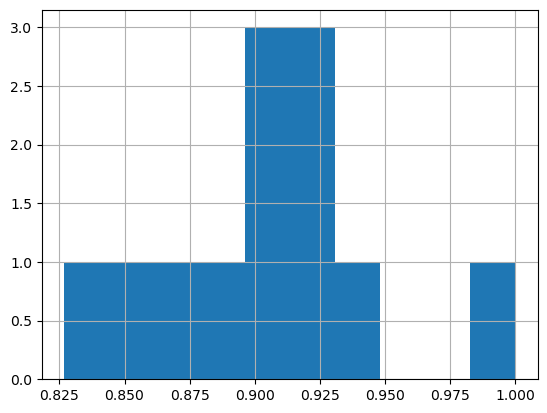

In [113]:
# looking much better now

dose_missing_df.filter(regex="_frac").apply(sum,axis=1).hist()

In [114]:
# dose_missing_df.filter(regex="(_frac)|(country_code)")
dose_light_combined = dose_light_combined.merge(dose_missing_df.filter(regex="(_frac)|(country_code)|(grp_usd_2015)"),left_on="gid_0",right_on="country_code",how="left",suffixes=["_dose","_wdi"])

In [115]:
dose_light_combined.columns

Index(['country', 'gid_0', 'gid_1', 'grp_usd_2015_dose', 'services_usd_2015',
       'manufacturing_usd_2015', 'agriculture_usd_2015', 'country_code',
       'grp_usd_2015_wdi', 'services_frac', 'manufacturing_frac',
       'agriculture_frac'],
      dtype='object')

In [116]:
dose_light_combined.tail(3)

,country,gid_0,gid_1,grp_usd_2015_dose,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015,country_code,grp_usd_2015_wdi,services_frac,manufacturing_frac,agriculture_frac
1646,"Yemen, Rep.",YEM,YEM,4.244449e+10,1.779608e+10,1.437432e+10,8.576307e+09,NaN,NaN,NaN,NaN,NaN
1647,Zambia,ZMB,ZMB,2.125122e+10,1.194752e+10,7.152575e+09,1.058488e+09,NaN,NaN,NaN,NaN,NaN
1648,Zimbabwe,ZWE,ZWE,1.996312e+10,1.170858e+10,4.463433e+09,1.653794e+09,NaN,NaN,NaN,NaN,NaN


In [117]:
missing_agriculture = dose_light_combined[dose_light_combined["agriculture_usd_2015"].isna()].index
missing_services = dose_light_combined[dose_light_combined["services_usd_2015"].isna()].index
missing_manufacturing = dose_light_combined[dose_light_combined["manufacturing_usd_2015"].isna()].index

missing_grp = dose_light_combined[dose_light_combined["grp_usd_2015_dose"].isna()].index

In [118]:
missing_grp

Index([865, 1206], dtype='int64')

In [119]:
dose_light_combined.loc[missing_agriculture,"agriculture_usd_2015"] = dose_light_combined.loc[missing_agriculture,"agriculture_frac"]*dose_light_combined.loc[missing_agriculture,"grp_usd_2015_dose"]

dose_light_combined.loc[missing_manufacturing,"manufacturing_usd_2015"] = dose_light_combined.loc[missing_manufacturing,"manufacturing_frac"]*dose_light_combined.loc[missing_manufacturing,"grp_usd_2015_dose"]

dose_light_combined.loc[missing_services,"services_usd_2015"] = dose_light_combined.loc[missing_services,"services_frac"]*dose_light_combined.loc[missing_services,"grp_usd_2015_dose"]

# dose_light_combined.loc[missing_grp,"grp_usd_2015"] = dose_light_combined.loc[missing_services,"grp_usd_2015_"]

In [120]:
dose_light_combined.iloc[missing_grp]

,country,gid_0,gid_1,grp_usd_2015_dose,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015,country_code,grp_usd_2015_wdi,services_frac,manufacturing_frac,agriculture_frac
865,Philippines,PHL,PHL.109_1,NaN,NaN,NaN,NaN,PHL,3.064459e+11,0.585215,0.304820,0.109965
1206,Tanzania,TZA,None,NaN,NaN,NaN,NaN,TZA,4.741392e+10,0.404312,0.244874,0.267459


In [121]:
dose_light_combined = dose_light_combined.drop(columns=["country_code","country",*[x for x in dose_light_combined.columns if re.search(string = x,pattern="(_frac)|(_2015_wdi)")]])

In [122]:
# still some NAs
print(dose_light_combined.loc[dose_light_combined.isna().any(axis=1)].shape)

dose_light_combined.loc[dose_light_combined.isna().any(axis=1)]

(16, 6)


,gid_0,gid_1,grp_usd_2015_dose,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
779,ANT,BES.1_1,4.660000e+08,NaN,NaN,NaN
780,ANT,BES.2_1,4.700000e+07,NaN,NaN,NaN
781,ANT,BES.3_1,1.340000e+08,NaN,NaN,NaN
865,PHL,PHL.109_1,NaN,NaN,NaN,NaN
1206,TZA,None,NaN,NaN,NaN,NaN
1526,ASM,ASM,6.730000e+08,NaN,NaN,NaN
1571,GUM,GUM,5.799000e+09,NaN,NaN,NaN
1582,KIR,KIR,1.915723e+08,NaN,NaN,NaN
1588,LIE,LIE,6.268515e+09,NaN,2.335665e+09,NaN
1600,MCO,MCO,6.261650e+09,5.159459e+09,1.102080e+09,NaN


In [123]:
print("Data to this point: ",dose_light_combined.shape)
print("Full row of NAs removed: ", dose_light_combined.dropna(axis=0,how="all").shape)
print("Some missing economic indicator removed: ", dose_light_combined.dropna(subset=["grp_usd_2015_dose","services_usd_2015","manufacturing_usd_2015","agriculture_usd_2015"],axis=0,how="any").shape)

Data to this point:  (1649, 6)
Full row of NAs removed:  (1649, 6)
Some missing economic indicator removed:  (1633, 6)


## Complementary filling

We have GDP = agriculture + manufacturing + services. If any single value of the rhs is missing, we can find it. If lhs is missing, we can sum rhs.

next, a function will check this. 

In [124]:
dose_light_combined.head(3)

,gid_0,gid_1,grp_usd_2015_dose,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,ALB,ALB.1_1,4.341915e+08,2.009631e+08,9.449606e+07,8.588401e+07
1,ALB,ALB.2_1,3.719427e+08,1.721516e+08,8.094841e+07,7.357106e+07
2,ALB,ALB.3_1,1.113524e+09,5.153885e+08,2.423439e+08,2.202575e+08


In [125]:
# function to find the missing values in rows and fill them if possible
def check_and_fill_row(row: pd.Series):
    lhs = [x for x in row.index.tolist() if re.search(string=x, pattern="(gdp)|(grp)")]
    rhs = [x for x in row.index.tolist() if re.search(string=x, pattern="(manufacturing)|(services)|(agriculture)")]

    if row[lhs].isna().item() and (not row[rhs].isna().any().item()):
        row[lhs]=row[rhs].sum()
    
    elif (not row[lhs].isna().item()) and row[rhs].isna().sum()==1:
        which = row[rhs].isna()[row[rhs].isna()].index.tolist()
        # assign to the missing values in the rhs, the value of the lhs minus the values of the other rhs variables.
        row[which] = row[lhs]-row[[x for x in rhs if x not in which]].sum()
    else:
        pass

    return row

In [126]:
dose_light_combined[dose_light_combined.isna().any(axis=1)] = dose_light_combined[dose_light_combined.isna().any(axis=1)].apply(check_and_fill_row,axis=1)


In [127]:
print("Data to this point: ",dose_light_combined.shape)
print("Full row of NAs removed: ", dose_light_combined.dropna(axis=0,how="all").shape)
print("Some missing economic indicator removed: ", dose_light_combined.dropna(subset=["grp_usd_2015_dose","services_usd_2015","manufacturing_usd_2015","agriculture_usd_2015"],axis=0,how="any").shape)

Data to this point:  (1649, 6)
Full row of NAs removed:  (1649, 6)
Some missing economic indicator removed:  (1636, 6)


In [128]:
# 6 values have no economic information at all and will be removed in the next step
dose_light_combined[dose_light_combined.isna().any(axis=1)]

,gid_0,gid_1,grp_usd_2015_dose,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
779,ANT,BES.1_1,4.660000e+08,NaN,NaN,NaN
780,ANT,BES.2_1,4.700000e+07,NaN,NaN,NaN
781,ANT,BES.3_1,1.340000e+08,NaN,NaN,NaN
865,PHL,PHL.109_1,NaN,NaN,NaN,NaN
1206,TZA,None,NaN,NaN,NaN,NaN
1526,ASM,ASM,6.730000e+08,NaN,NaN,NaN
1571,GUM,GUM,5.799000e+09,NaN,NaN,NaN
1582,KIR,KIR,1.915723e+08,NaN,NaN,NaN
1588,LIE,LIE,6.268515e+09,NaN,2.335665e+09,NaN
1604,NRU,NRU,8.486344e+07,NaN,NaN,NaN


In [129]:
# writing back the modified data set into the original one. this can be avoided and all the operations can be done on the original one right away once the workflow is good. 
dose_light_combined = dose_light_combined.dropna(subset=["grp_usd_2015_dose","services_usd_2015","manufacturing_usd_2015","agriculture_usd_2015"],axis=0,how="all")

## Validations
Running some tests on the data to identify problems

In [135]:
dose_light_combined[np.abs((dose_light_combined["grp_usd_2015_dose"]-dose_light_combined["manufacturing_usd_2015"]-dose_light_combined["services_usd_2015"]-dose_light_combined["agriculture_usd_2015"])/dose_light_combined["grp_usd_2015_dose"])>1.1]

,gid_0,gid_1,grp_usd_2015_dose,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
397,IND,IND.2_1,7.607693e+10,3.357343e+10,1.938657e+10,2.959954e+12
399,IND,IND.4_1,2.874776e+10,1.384176e+10,6.419377e+09,1.832131e+11
402,IND,IND.7_1,3.261214e+10,1.134110e+10,1.125099e+10,2.280518e+11
405,IND,IND.11_1,1.285709e+11,4.666193e+10,5.692669e+10,1.035249e+12
418,IND,IND.26_1,4.604805e+10,1.892777e+10,1.267556e+10,2.899032e+11
422,IND,IND.31_1,1.533122e+11,8.309745e+10,4.963792e+10,2.275526e+12
425,IND,IND.34_1,1.480320e+11,7.115388e+10,3.712522e+10,2.098595e+12
427,IND,IND.36_1,1.058850e+11,5.702616e+10,2.182926e+10,2.262062e+11
550,JPN,JPN.15_1,3.795022e+10,7.542466e+10,1.279874e+10,3.448848e+08
1104,KOR,KOR.12_1,1.375481e+10,9.949754e+09,5.067870e+10,3.974607e+09


In [ ]:
# dose_light.head(3)
wdi_df_var.head(3)

In [ ]:
dose_light

In [ ]:
wdi_df_var[wdi_df_var["grp_usd_2015"].isna()]

In [ ]:
val = (dose_light[["gid_0","grp_usd_2015"]]
    .groupby("gid_0").sum()
    .merge(wdi_df_full[["country","country_code","grp_usd_2015"]],how="left",left_on="gid_0",right_on="country_code",suffixes=("_dose","_wdi")))
val

In [ ]:
(val["grp_usd_2015_wdi"]-val["grp_usd_2015_dose"]).hist(bins=15) # .apply(np.log1p)

In [ ]:
abs_diff = (np.abs(val["grp_usd_2015_wdi"]-val["grp_usd_2015_dose"])/val["grp_usd_2015_dose"])#.isna()#.hist(bins=15)

# we aim to cluster all the values close to 0
abs_diff.hist(bins=10)

In [ ]:
val.loc[(np.abs(val["grp_usd_2015_wdi"]-val["grp_usd_2015_dose"])/val["grp_usd_2015_dose"]) > .15,]

In [ ]:
import os

version = "0_2"

dir_name = f"../datasets/local_data/dose-wdi/"

filename_dose_light = f"{dir_name}{version}/dose_light_combined_{year}_{version}.csv"
filename_dose_light


In [ ]:

if not os.path.exists(f"{dir_name}{version}"):
    os.mkdir(f"{dir_name}{version}")

if os.path.exists(filename_dose_light):
    print(Warning("File already exists, erase before if you want to regenerate, or update version"))
    # dose_light_combined.to_csv()
else: 
    print(f"Writing file locally to '{filename_dose_light}'.")
    dose_light_combined.to_csv(filename_dose_light,index=False)

### Reading the local file

In [ ]:
if os.path.exists(filename_dose_light):
    print("Reading local file")
    dose_light_combined = pd.read_csv(filename_dose_light)
else :
    raise IOError("Could find file.")

In [ ]:
print(dose_light_combined.shape)
dose_light_combined.head(3)

In [ ]:
dose_light_combined.loc[dose_light_combined["grp_usd_2015_dose"].isna()]

In [ ]:
print((dose_light_combined.dropna(axis=0,ignore_index=True,subset=["grp_usd_2015_dose"]).shape[0])/dose_light_combined.shape[0])

dose_light_combined.dropna(axis=0,ignore_index=True,subset=["grp_usd_2015_dose"]).head(5)

In [ ]:
dose_light_combined.dropna(axis=0,ignore_index=True,subset=["services_usd_2015"])

In [ ]:
dose_light_combined.dropna(axis=0,ignore_index=True,subset=["manufacturing_usd_2015"])

In [ ]:
dose_light_combined.dropna(axis=0,ignore_index=True,subset=["agriculture_usd_2015"])

### Checking if things add up

In [ ]:
(dose_light_combined["grp_usd_2015_dose"]-dose_light_combined["manufacturing_usd_2015"]-dose_light_combined["services_usd_2015"]-dose_light_combined["agriculture_usd_2015"]).hist()

## H3 with duckdb

testing the duckdb h3 extension to potentially transfer all the projection on the db side for better performance.

In [ ]:
res = conn.raw_sql("""INSTALL h3 FROM community;
                   LOAD h3;""").df()

res

In [ ]:

conn.sql("SELECT h3_cell_to_latlng('822d57fffffffff');")

conn.sql("SELECT h3_cell_to_boundary_wkt('822d57fffffffff');")